In [18]:
## importing libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir('/media/shubham/3AA25FBFA25F7DF7/Kaggle/russian housing market')
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder

In [12]:
## reading files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [13]:
#### preprocessing ####

## missing values
for i in train.columns:
    if train[i].dtype == 'object':
        train[i] = train[i].fillna(train[i].mode().iloc[0])
    if (train[i].dtype == 'int' or train[i].dtype == 'float'):
        train[i] = train[i].fillna(np.mean(train[i]))
for i in test.columns:
    if test[i].dtype == 'object':
        test[i] = test[i].fillna(test[i].mode().iloc[0])
    if (test[i].dtype == 'int' or test[i].dtype == 'float'):
        test[i] = test[i].fillna(np.mean(test[i]))

## label encoding
number = LabelEncoder()
for i in train.columns:
    if (train[i].dtype == 'object'):
        train[i] = number.fit_transform(train[i].astype('str'))
        train[i] = train[i].astype('object')
        
for i in test.columns:
    if (test[i].dtype == 'object'):
        test[i] = number.fit_transform(test[i].astype('str'))
        test[i] = test[i].astype('object')

In [22]:
## creating a new feature origin
train['origin'] = 0
test['origin'] = 1
training = train.drop('price_doc',axis=1) #droping target variable

In [26]:
## taking sample from training and test data
training = training.sample(7662, random_state=12)
#testing = test.sample(7000, random_state=11)

In [27]:
## combining random samples
combi = training.append(test)
y = combi['origin']
combi.drop('origin',axis=1,inplace=True)

In [28]:
## modelling
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for i in combi.columns:
    score = cross_val_score(model,pd.DataFrame(combi[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.8):
        drop_list.append(i)
        print(i,np.mean(score))

id 0.875815713913
life_sq 0.856597962561
kitch_sq 0.894301021881
hospital_beds_raion 0.882621122891
cafe_sum_500_min_price_avg 0.839616174389
cafe_sum_500_max_price_avg 0.837342668354
cafe_avg_price_500 0.838653925807


Drifting features : {id, life_sq, kitch_sq, hospital_beds_raion, cafe_sum_500_min_price_avg, cafe_sum_500_max_price_avg, cafe_avg_price_500 }

# Prediction

In [29]:
## using a basic model with all the features
training = train.drop('origin',axis=1)
testing = test.drop('origin',axis=1)

rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
rf.fit(training.drop('price_doc',axis=1),training['price_doc'])
pred = rf.predict(testing)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = test['id']
sub = sub[['id','price_doc']]
sub.to_csv('with_drifting.csv', index=False)

On submitting this file on kaggle, we are getting a score of 0.40116 on private leaderboard.

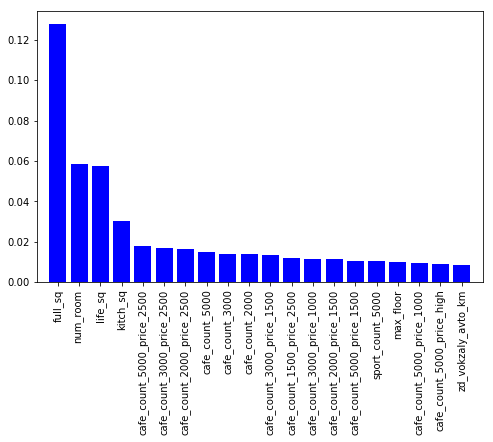

In [34]:
## checking variable importances
### plotting importances
features = training.drop('price_doc',axis=1).columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

In [42]:
drop_list

['id',
 'life_sq',
 'kitch_sq',
 'hospital_beds_raion',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500']

In [38]:
## model while dropping all the drifting features

## dropping drifting features which are not important.
drift_train = training.drop(['id','hospital_beds_raion','cafe_sum_500_min_price_avg','cafe_sum_500_max_price_avg','cafe_avg_price_500'], axis=1)
drift_test = testing.drop(['id','hospital_beds_raion','cafe_sum_500_min_price_avg','cafe_sum_500_max_price_avg','cafe_avg_price_500'], axis=1)

rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
rf.fit(drift_train.drop('price_doc',axis=1),training['price_doc'])
pred = rf.predict(drift_test)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = test['id']
sub = sub[['id','price_doc']]
sub.to_csv('without_drifting.csv', index=False)

On submitting this file on kaggle, we are getting a score of 0.39759 on private leaderboard.

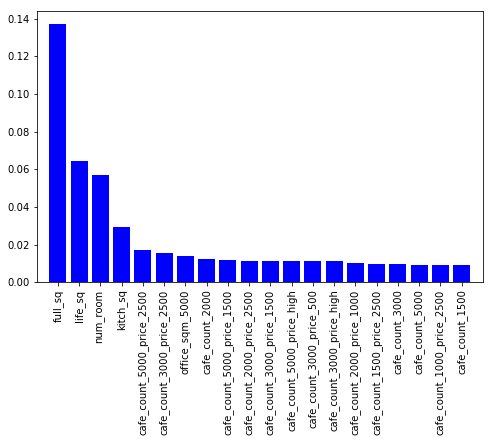

In [41]:
## checking variable importances
### plotting importances
features = drift_train.columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()